In [1]:
!pip install torch torchvision opencv-python matplotlib numpy
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-f6pq4ans
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-f6pq4ans
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=4ab85bfd681ea037d60b8fe842c062a09a721a7052ada628ec481decff8fbdee
  Stored in directory: /tmp/pip-ephem-wheel-cache-fyfqghua/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [2]:
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [3]:
# Model configuration
MODEL_TYPE = "vit_h"
SAM_CHECKPOINT = "sam_vit_h_4b8939.pth"

# Output directory
OUTPUT_DIR = "output_receipts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# Load image
image = cv2.imread("/content/quis.jpeg")   # make sure input.jpg is uploaded to Colab
assert image is not None, "Image not found!"

# Convert for SAM
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Image dimensions
H, W, _ = image.shape

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Download checkpoint if missing
if not os.path.exists(SAM_CHECKPOINT):
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# Load model
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
sam.to(device=device)

# Mask generator
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=16,        # reduced for Colab stability
    pred_iou_thresh=0.9,
    stability_score_thresh=0.92,
    min_mask_region_area=5000
)

Using device: cpu
--2026-02-04 14:36:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.169.121.107, 3.169.121.81, 3.169.121.110, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.169.121.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   257MB/s    in 9.9s    

2026-02-04 14:36:22 (246 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [6]:
masks = mask_generator.generate(image_rgb)
print("Number of masks detected:", len(masks))

Number of masks detected: 41


In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

In [8]:
receipt_count = 0

for mask in masks:
    seg = mask["segmentation"].astype(np.uint8)

    ys, xs = np.where(seg == 1)
    if len(xs) == 0 or len(ys) == 0:
        continue

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()

    w = x2 - x1
    h = y2 - y1
    area = w * h

    if area < 0.03 * (H * W):
        continue

    aspect_ratio = h / (w + 1e-5)
    if aspect_ratio < 1.2:
        continue

    crop = image[y1:y2, x1:x2]
    crop_edges = edges[y1:y2, x1:x2]

    edge_density = np.sum(crop_edges > 0) / (crop_edges.size + 1e-6)
    if edge_density < 0.02:
        continue

    receipt_count += 1
    cv2.imwrite(f"{OUTPUT_DIR}/receipt_{receipt_count}.png", crop)

print("Receipts saved:", receipt_count)

Receipts saved: 5


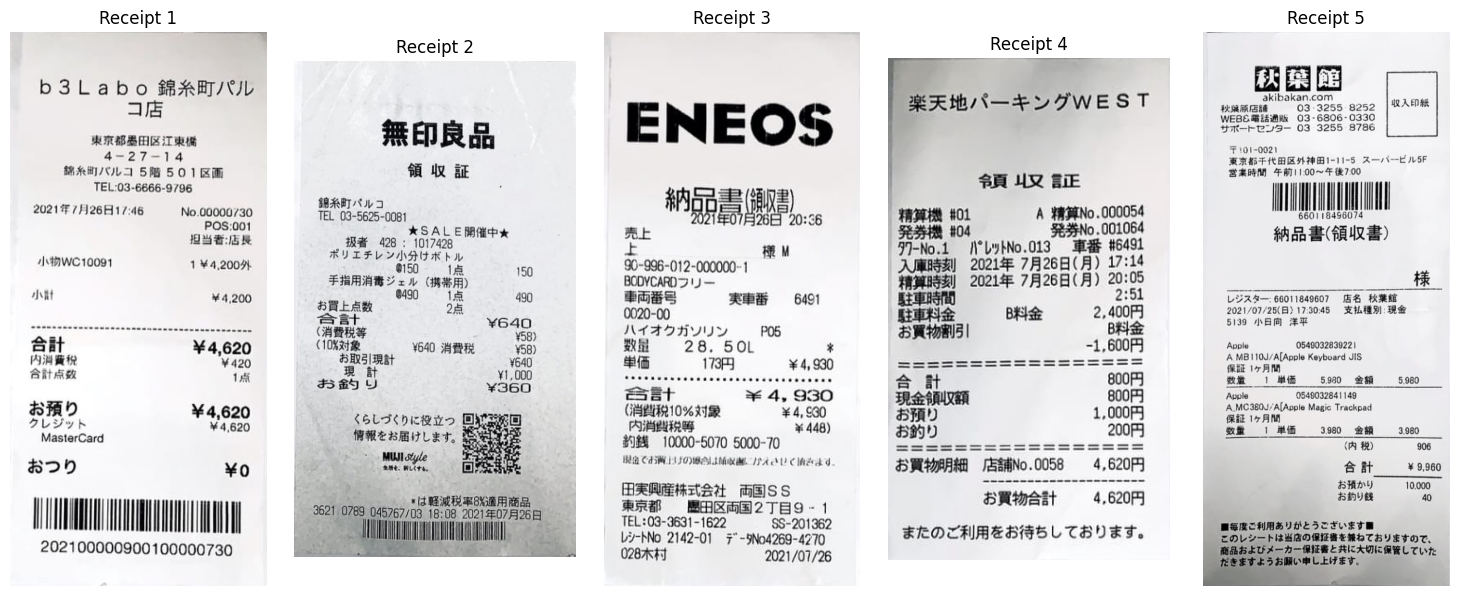

In [9]:
files = sorted(os.listdir(OUTPUT_DIR))
plt.figure(figsize=(15, 6))

for i, f in enumerate(files):
    img = cv2.imread(os.path.join(OUTPUT_DIR, f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(files), i + 1)
    plt.imshow(img)
    plt.title(f"Receipt {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()